In [35]:
#  import vist
import matplotlib.pyplot as plt
from datetime import datetime
from pprint import pprint
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)

In [200]:
import os.path as osp
import json
import numpy as np
import math
from datetime import datetime
from pprint import pprint
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt

class Story_in_Sequence:	def __init__(self, images_dir, annotations_dir, splits=None):
        
        
		"""
		The vist_dir should contain images and annotations, which further contain train/val/test.
		We will load train/val/test together on default and add split in albums, and make mapping.
		- albums  = [{id, title, vist_label, description, img_ids, story_ids}]
		- images  = [{id, album_id, datetaken, title, text, tags}]
		- sents   = [{id, story_id, album_id, img_id, order, original_text, text, length}]
		- stories = [{id, story_id, album_id, sent_ids, img_ids}]
		"""
		self.images_dir = images_dir
		self.annotations_dir = annotations_dir
		self.prompts =[]
        

		# Load annotations and add splits to each album
		if not splits:
			splits = ['train', 'val', 'test']
		sis = {'images': [], 'albums': [], 'annotations': []}
		for split in splits:
			b = datetime.now()
			if split == 'train':
				info = json.load(open('train.story-in-sequence.json'))
				print('here')
			elif (split == 'test'):
				print('here test')
				info = json.load(open('test.story-in-sequence.json'))
			elif (split == 'val'):
				print('here val')
				info = json.load(open('val.story-in-sequence.json'))
            
                
                
            

# 			info = json.load(open(osp.join(self.annotations_dir, 'sis', split+'.story-in-sequence.json')))
			print ('sis\'s [%s] loaded. It took %.2f seconds.' % (split, (datetime.now() - b).total_seconds()))
			for album in info['albums']:
				album['split'] = split
			sis['albums'] += info['albums']
			sis['images'] += info['images']
			sis['annotations'] += info['annotations']

		sents = []
		for ann in sis['annotations']:
			# sent = {album_id, img_id, story_id, text, original_text, }
			sent = ann[0].copy()
			sent['id'] = sent.pop('storylet_id')
			sent['order'] = sent.pop('worker_arranged_photo_order')
			sent['img_id'] = sent.pop('photo_flickr_id')
			sent['length'] = len(sent['text'].split())  # add length property
			sents += [sent]

		# make mapping
		print ('Make mapping ...')
		self.Albums = {album['id']: album for album in sis['albums']}
		self.Images = {img['id']: img for img in sis['images']}
		self.Sents  = {sent['id']: sent for sent in sents}

		# album_id -> img_ids
		album_to_img_ids = {}
		for img in sis['images']:
			album_id = img['album_id']
			img_id = img['id']
			album_to_img_ids[album_id] = album_to_img_ids.get(album_id, []) + [img_id]
		def getDateTime(img_id):
			x = self.Images[img_id]['datetaken']
			return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
		for album_id, img_ids in album_to_img_ids.items():
			img_ids.sort(key=getDateTime)

		# story_id -> sent_ids
		story_to_sent_ids = {}
		for sent_id, sent in self.Sents.items():
			story_id = sent['story_id']
			story_to_sent_ids[story_id] = story_to_sent_ids.get(story_id, []) + [sent_id]
		def get_order(sent_id):
			return self.Sents[sent_id]['order']
		for story_id, sent_ids in story_to_sent_ids.items():
			sent_ids.sort(key=get_order)

		# album_id -> story_ids
		album_to_story_ids = {}
		for story_id, sent_ids in story_to_sent_ids.items():
			sent = self.Sents[sent_ids[0]]
			album_id = sent['album_id']
			album_to_story_ids[album_id] = album_to_story_ids.get(album_id, []) + [story_id]

		# add to albums (and self.Albums)
		for album in sis['albums']:
			album['img_ids'] = album_to_img_ids[album['id']]
			album['story_ids'] = album_to_story_ids[album['id']]

		# make Stories: {story_id: {id, album_id, sent_ids, img_ids}}
		self.Stories = {story_id: {'id': story_id, 
								   'sent_ids': sent_ids, 
								   'img_ids': [self.Sents[sent_id]['img_id'] for sent_id in sent_ids],
								   'album_id': self.Sents[sent_ids[0]]['album_id']} 
			for story_id, sent_ids in story_to_sent_ids.items()}

		print ('Mapping for [Albums][Images][Stories][Sents] done.')

		# back to albums, images, stories, sents
		self.albums = self.Albums.values()
		self.images = self.Images.values()
		self.stories = self.Stories.values()
		self.sents = self.Sents.values()


	def read_img(self, img_file):
		img_content = imread(img_file)
		if len(img_content.shape) == 2:
			img_content = np.tile(img_content[:,:,np.newaxis], (1,1,3))
		img_content = imresize(img_content, (224, 224))
		return img_content

	def show_story(self, story_id, show_image=True, show_sents=True):
		storieslist = []
		story = self.Stories[story_id]
		sent_ids = story['sent_ids']
		if show_image:
			plt.figure()
			for i, sent_id in enumerate(sent_ids):
				img_id = self.Sents[sent_id]['img_id']
				img = self.Images[img_id]
				album_id = img['album_id']
				split = self.Albums[album_id]['split']
				img_file = osp.join('train/', img_id + '.jpg')
				img_content = self.read_img(img_file)
				ax = plt.subplot(1, len(sent_ids), i+1)
				ax.imshow(img_content)
				ax.axis('off')
				ax.set_title(str(img_id)+'\n'+img['datetaken'][5:])
			plt.show()
		if show_sents:
			for sent_id in sent_ids:
				sent = self.Sents[sent_id]
				storieslist.append(sent['text'])               
				print ('%s: img_id[%s], %s' % (sent['order'], sent['img_id'], sent['text']))
			self.prompts.append(storieslist)
            
	def make_prompt(self, story_id, show_image=True, show_sents=True):
		storieslist = []
		story = self.Stories[story_id]
		sent_ids = story['sent_ids']
		if show_sents:
			for sent_id in sent_ids:
				sent = self.Sents[sent_id]
				storieslist.append(sent['text'])               
# 				print ('%s: img_id[%s], %s' % (sent['order'], sent['img_id'], sent['text']))
			self.prompts.append(storieslist)


	def show_album(self, album_id):
		album = self.Albums[album_id]
		img_ids = album['img_ids']
		plt.figure()
		cols = 5
		rows = math.ceil(len(img_ids)/float(cols))
		for i, img_id in enumerate(img_ids):
			img = self.Images[img_id]
# 			img_file = osp.join(self.images_dir, album['split'], img_id + '.jpg')
			img_file = osp.join('train/', img_id + '.jpg')
# 			img_file = osp.join(self.images_dir, album['split'], img_id + '.jpg')
			img_content = self.read_img(img_file)
			ax = plt.subplot(rows, cols, i+1)
			ax.imshow(img_content)
			ax.axis('off')
			ax.set_title(str(img_id)+'\n'+img['datetaken'][5:])
		plt.show()


### Load Story-in-Sequence Instance

In [201]:
vist_images_dir = '/train'
vist_annotations_dir = '/vist_dataset/annotations'
sis = Story_in_Sequence(vist_images_dir, vist_annotations_dir)

here
sis's [train] loaded. It took 1.68 seconds.
here val
sis's [val] loaded. It took 0.13 seconds.
here test
sis's [test] loaded. It took 0.12 seconds.
Make mapping ...
Mapping for [Albums][Images][Stories][Sents] done.


In [134]:
sis.Albums['72157605930515606']

{'description': 'Believed to be the largest Moreton Bay Fig Tree in the united States',
 'title': 'Moreton Bay Fig 1877',
 'farm': '4',
 'date_update': '1432330952',
 'primary': '2626985925',
 'server': '3104',
 'date_create': '1214980972',
 'photos': '13',
 'secret': '98149cd59b',
 'owner': '12806074@N08',
 'vist_label': '4th_of_july',
 'id': '72157605930515606',
 'split': 'train',
 'img_ids': ['2626977325',
  '2627795780',
  '2762593799',
  '2626979987',
  '2701863545',
  '2627798290',
  '2626982337',
  '2626983575',
  '2627801768',
  '2626985925',
  '2626987089',
  '2627805194',
  '2627807506'],
 'story_ids': ['30355', '30356', '30357', '30358', '30359']}

### Let's check one album.

/Users/amahdavi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/amahdavi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


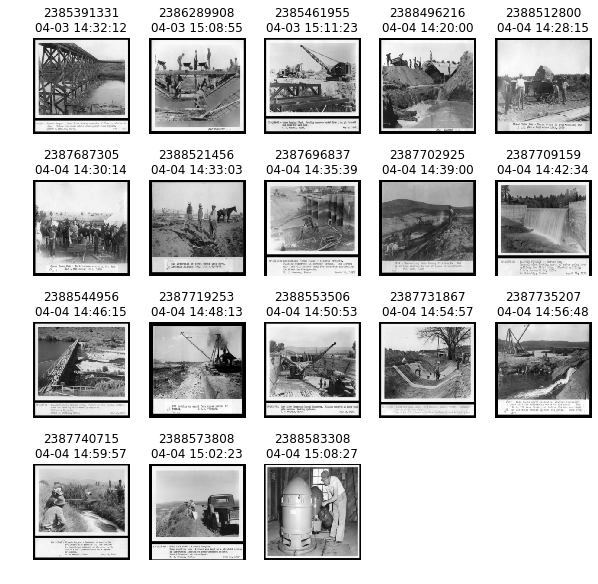

In [215]:
album_id = list(sis.Albums.keys())[3]
sis.show_album(album_id)
album = sis.Albums[album_id]
# pprint(album)

['5', '6', '7', '8', '9']


/Users/amahdavi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/amahdavi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


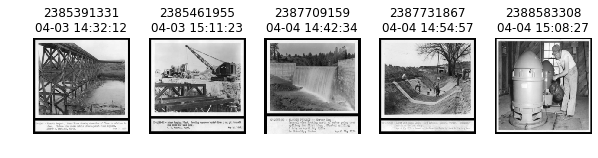

0: img_id[2385391331], the city in 1940 decided to build a water dam .
1: img_id[2385461955], over 100 's of construction trucks .
2: img_id[2387709159], the city dam was used to generate power to the city .
3: img_id[2387731867], the construction workers began leveling the ground for the water dam .
4: img_id[2388583308], water pumps were used to control the water flow of the dam .
['2385391331', '2385461955', '2387709159', '2387731867', '2388583308']


In [216]:

story_ids = sis.Albums[album_id]['story_ids']
print(story_ids)
story_id = story_ids[0]
sis.show_story(story_id)
print (sis.Stories[story_id]['img_ids'])

In [188]:
for album_id in list(sis.Albums.keys()):
    story_ids = sis.Albums[album_id]['story_ids']
#     print(story_ids)
    story_id = story_ids[0]
    sis.make_prompt(story_id)
#     print (sis.Stories[story_id]['img_ids'])

In [189]:
sis.prompts

[['our landmark tree in town was about to be destroyed and cleared for a new mall .',
  'so we decided to take the day to go out and enjoy its beauty .',
  'to see the final glimpse of the roots , extending out into the depths of the hill .',
  'and its magnificent trunk , larger than life itself .',
  'one last picture of its beauty so we could capture it forever .'],
 ['our trip to location last year was filled with beauty . sculptures could be found everywhere we went .',
  'the architecture was old and interesting .',
  'since it was spring , beautiful flowers lined the streets . this pink bloom was particularly lovely .',
  'we went to a museum and saw this odd collection of hanging faces !',
  "i 'd have to say my favorite part of the trip would have to be the food though . we ca n't wait to go back again !"],
 ['[male] and i were excited to be in location location during the 4th of july .',
  'there was a huge crowd of people already awaiting the firework show .',
  'we were luc

In [184]:
prompts = []
for story in sis.prompts:
    s = ""
    for sentence in story:
        s += sentence
    prompts.append(s)
prompts        

['our landmark tree in town was about to be destroyed and cleared for a new mall .so we decided to take the day to go out and enjoy its beauty .to see the final glimpse of the roots , extending out into the depths of the hill .and its magnificent trunk , larger than life itself .one last picture of its beauty so we could capture it forever .',
 "our trip to location last year was filled with beauty . sculptures could be found everywhere we went .the architecture was old and interesting .since it was spring , beautiful flowers lined the streets . this pink bloom was particularly lovely .we went to a museum and saw this odd collection of hanging faces !i 'd have to say my favorite part of the trip would have to be the food though . we ca n't wait to go back again !",
 '[male] and i were excited to be in location location during the 4th of july .there was a huge crowd of people already awaiting the firework show .we were lucky to find a nice spot on the grass to watch the show .as the eve

### Check its story

## Here are some stats about SIS dataset.

In [153]:
# # albums stats
# split_to_album_ids = {'train': [], 'val': [], 'test': []}
# total_albums = 0
# for split in ['train', 'val', 'test']:
#     split_to_album_ids[split] = [album_id for album_id, album in sis.Albums.items() if album['split'] == split]
#     print ('There are [%s] albums in [%s] split.' % (len(split_to_album_ids[split]), split))
#     total_albums += len(split_to_album_ids[split])
# print ('In total, there are [%s] albums.' % total_albums)

There are [8031] albums in [train] split.
There are [998] albums in [val] split.
There are [1011] albums in [test] split.
In total, there are [10040] albums.


In [155]:
# # stories stats
# split_to_story_ids = {'train': [], 'val': [], 'test': []}
# for story in sis.stories:
#     album_id = story['album_id']
#     split = sis.Albums[album_id]['split']
#     split_to_story_ids[split] += [story['id']]
# total_stories = 0
# for split in ['train', 'val', 'test']:
#     print ('There are [%s] stories in [%s] split.' % (len(split_to_story_ids[split]), split))
#     total_stories += len(split_to_story_ids[split])
# print ('In total, there are [%s] stories.' % (total_stories))

There are [40155] stories in [train] split.
There are [4990] stories in [val] split.
There are [5055] stories in [test] split.
In total, there are [50200] stories.


In [7]:
# # sents stats
# print 'SIS:'
# split_to_sent_ids = {'train': [], 'val': [], 'test': []}
# for sent in sis.sents:
#     album_id = sent['album_id']
#     split = sis.Albums[album_id]['split']
#     split_to_sent_ids[split] += [sent['id']]
# total_sents = 0
# for split in ['train', 'val', 'test']:
#     print 'There are [%s] sents in [%s] split.' % (len(split_to_sent_ids[split]), split)
#     total_sents += len(split_to_sent_ids[split])
# print ('In total, there are [%s] sents.' % (total_sents))

SIS:
There are [200775] sents in [train] split.
There are [24950] sents in [val] split.
There are [25275] sents in [test] split.
In total, there are [251000] sents.


In [8]:
# # check story order
# def check_dts_order(dts):
#     flag = True
#     for i in range(1, len(dts)):
#         if dts[i] <= dts[i-1]:
#             flag = False
#     return flag

# inorder = 0
# for story in sis.stories:
#     dts = []
#     for i, sent_id in enumerate(story['sent_ids']):
#         sent = sis.Sents[sent_id]
#         assert sent['order'] == i
#         img = sis.Images[sent['img_id']]
#         dt = datetime.strptime(img['datetaken'], '%Y-%m-%d %H:%M:%S')
#         dts += [dt]
#     if check_dts_order(dts):
#         inorder += 1
# print ('Among %s stories, %s [%.2f%%] are in order' % (len(sis.stories), inorder, inorder*100.0/len(sis.stories)))

Among 50200 stories, 31481 [62.71%] are in order


In [9]:
# img_ids = sis.Stories[story_id]['img_ids']
# dii.show_imgs_with_sents(img_ids, False)

In [12]:
# # Load DII instance
# dii = vist.Description_in_Isolation(vist_images_dir, vist_annotations_dir)

# # DII's sents stats
# print ('DII:')
# dii_split_to_sent_ids = {'train': [], 'val': [], 'test': []}
# for sent in dii.sents:
#     album_id = sent['album_id']
#     split = dii.Albums[album_id]['split']
#     dii_split_to_sent_ids[split] += [sent['id']]
# total_sents = 0
# for split in ['train', 'val', 'test']:
#     print 'There are [%s] sents in [%s] split.' % (len(dii_split_to_sent_ids[split]), split)
#     total_sents += len(dii_split_to_sent_ids[split])
# print ('In total, there are [%s] sents.' % (total_sents))

dii's [train] loaded. It took 6.67 seconds.
dii's [val] loaded. It took 0.47 seconds.
dii's [test] loaded. It took 0.54 seconds.
Make mapping ...
Mapping for [Albums][Images][Sents] done.
DII:
There are [120465] sents in [train] split.
There are [14970] sents in [val] split.
There are [15165] sents in [test] split.
In total, there are [150600] sents.
